# Sysco CA Sell-out

Goal: 
1. Process Sysco CA data
2. Analyze data using COVID segmentation
3. Compare sell-out (Sysco CA) to sell-in (McCain) data

### 1. Load libraries, initiate folder/file paths
Run cell below

In [1]:
import pandas as pd
import datetime
from datetime import datetime as dt
import numpy as np
import pyodbc

from distributor_transformation import transform_sysco_ca, set_dictionary, set_time
from sellout_model import process_list, analyze, add_time
#from sellout_teradata import teradata_sales
from sellout_import import import_sysco_ca, all_df, import_gfs_ca
from sellout_azure import azure_sellin

In [2]:
DICTIONARY = set_dictionary()
TIME = set_time(DICTIONARY)

In [3]:
data = import_sysco_ca()

data['PeriodStart'] = pd.to_datetime(data['PeriodStart'])
data['PeriodEnd'] = pd.to_datetime(data['PeriodEnd'])

print(data['PeriodEnd'].agg(['min','max']))

Query ran for Sysco CA under sales org CA01 for sales on or before 2025-01-19
Query took 24.0 seconds
min   2018-07-07
max   2025-01-11
Name: PeriodEnd, dtype: datetime64[ns]


In [12]:
data[(data['PeriodEnd'] > '2023-12-29') & (data['PeriodEnd'] < '2024-03-03')].groupby(['PeriodEnd'])['Cases'].sum()[-10:]

PeriodEnd
2023-12-30     85889.0
2024-01-06     86724.0
2024-01-13     96381.0
2024-01-20     97700.0
2024-01-27    104108.0
2024-02-03    104856.0
2024-02-10    107358.0
2024-02-17    107927.0
2024-02-24    103584.0
2024-03-02    105961.0
Name: Cases, dtype: float64

In [4]:
data.groupby(['PeriodEnd'])['Cases'].sum()[-10:]

PeriodEnd
2024-09-07    117139.0
2024-09-14    107086.0
2024-09-21    112427.0
2024-09-28    114529.0
2024-10-05    151013.0
2024-10-12    115906.0
2024-10-19    138945.0
2024-10-26    112890.0
2024-11-02    112615.0
2024-11-09    114156.0
Name: Cases, dtype: float64

### Copy last 5 reporting periods to clipboard
- Used to report anomolies back to Graham/data engineers

In [4]:
_base = transform_sysco_ca(data, 'Sysco - CA.xlsx')

Shape before adding dictionary: (179613, 9)
Total before dictionary: 806842238.7039424
Total after dictionary: 806842238.7039424
Shape after adding dictionary: (179613, 16)
The following segments are missing:
     sector                                            segment   subsegment  \
0    Broker                                              Other          NaN   
1       MEU                             Fast Food/ Fast Casual  Bakery Café   
2       MEU                                Schools & Education          NaN   
3  MEU - IO  Grocery - Convenience & Forecourts/Fuel (Gas) ...          NaN   
4       NaN                             Fast Food/ Fast Casual       Others   

     LBS  
0   58.4  
1   13.5  
2   30.0  
3  156.0  
4  418.0  


In [5]:
_list = []

#Output 1: COVID L1 - List 0
_list.append(['City', 'Region','COVID Segmentation - L1','COVID Segmentation - L2','Restaurant Service Type','Consolidated Category'])

print(f'Processing Region', flush = True)

output1 = process_list(_base, _list[0], 'Sysco CA')

Processing Region


In [10]:
print(f'Processing Sell in vs Sell out', flush = True)
output2 = azure_sellin(_base, 'CA01', "','".join(['6500002815', '6500002893']), 'Sysco CA')


Processing Sell in vs Sell out
Query ran for 6500002815','6500002893 under sales org CA01 for sales on or before 2024-05-12
All done, took 50.0 seconds...


In [6]:
output1.to_csv('files/sellout_region_sysco_ca.zip', compression='zip', index=False)
#output2.to_csv('files/sellout_sellin_sysco_ca.zip', compression='zip', index=False)

In [8]:
test = pd.read_csv('files/sellout_region_sysco_ca.zip', compression='zip')

test.head()

,City,Region,COVID Segmentation - L1,COVID Segmentation - L2,Restaurant Service Type,Consolidated Category,Calendar Week Year,Distributor,LBS,SMA_4,...,LBS_Lag_4,LBS_Baseline_Lag_1,LBS_LY_Lag_1,SMA_4_Lag_1,SMA_4_LY_Lag_1,SMA_4_Baseline_Lag_1,LBS_PRECOVID,Week Starting (Sun),Week Ending (Sat),COVID Week
0,NaN,NaN,Accommodation,"Hotels, Casinos & Resorts",Not Applicable,Potato,201901.0,Sysco CA,83768.28,83768.28,...,0.00,2.00,2.00,0.00,0.0,0.00,53329.81,2018-12-30,2019-01-05,0.0
1,NaN,NaN,Accommodation,"Hotels, Casinos & Resorts",Not Applicable,Potato,201902.0,Sysco CA,75071.63,79419.95,...,0.00,83768.28,83768.28,83768.28,0.0,83768.28,53329.81,2019-01-06,2019-01-12,0.0
2,NaN,NaN,Accommodation,"Hotels, Casinos & Resorts",Not Applicable,Potato,201903.0,Sysco CA,87217.60,82019.17,...,0.00,75071.63,75071.63,79419.95,0.0,79419.95,53329.81,2019-01-13,2019-01-19,0.0
3,NaN,NaN,Accommodation,"Hotels, Casinos & Resorts",Not Applicable,Potato,201904.0,Sysco CA,86529.45,83146.74,...,0.00,87217.60,87217.60,82019.17,0.0,82019.17,53329.81,2019-01-20,2019-01-26,0.0
4,NaN,NaN,Accommodation,"Hotels, Casinos & Resorts",Not Applicable,Potato,201905.0,Sysco CA,92675.02,85373.42,...,83768.28,86529.45,86529.45,83146.74,0.0,83146.74,53329.81,2019-01-27,2019-02-02,0.0


In [9]:
mask = (test['Distributor'] == 'Sysco CA')

test[mask]['Week Ending (Sat)'].max()

'2024-11-09'

## GFS

In [9]:
data_gfs = import_gfs_ca()

Query ran for GFS CA under sales org CA01 for sales on or before 2024-02-25
Query took 17.0 seconds


In [10]:
data_gfs.head()

,PeriodStart,PeriodEnd,sector,segment,subsegment,category,LBS,Cases


In [16]:
import pyodbc

_start = dt.now()

server = 'azure-synapse-workspace-01-prod.sql.azuresynapse.net'
database = 'GDASQLPool01PROD'
driver= '{ODBC Driver 17 for SQL Server}'
active = 'ActiveDirectoryIntegrated'

cnxn = pyodbc.connect('DRIVER='+driver+';SERVER=tcp:'+server+';PORT=1433;DATABASE='+database+';Authentication='+active)

date = dt.now()
date = date - datetime.timedelta(days=date.weekday()+1)
date = date.strftime('%Y-%m-%d')

print(f'Query ran for Sysco CA under sales org CA01 for sales on or before {date}')

sql = '''
    SELECT
    a1.[PeriodStart]
    ,a1.[PeriodEnd]
    ,a2.[Sector__c] as sector
    ,a2.[Operator_Segment__c] as segment
    ,a2.[Sub_Segment__c] as subsegment
    ,a3.[Product_Category__c] as category
    ,SUM(a1.[SalesLbs]) as LBS
    FROM [BI].[Factsellout] as a1
    JOIN [cur].[account] as a2
        on a1.[OperatorID] = a2.[Id]
    LEFT JOIN [cur].[product2] as a3
        on REPLACE(LTRIM(REPLACE(a1.[ProductId], '0', ' ')), ' ', '0') = a3.[ProductCode]
    GROUP BY
    a1.[PeriodStart]
    ,a1.[PeriodEnd]
    ,a2.[Sector__c]
    ,a2.[Operator_Segment__c]
    ,a2.[Sub_Segment__c]
    ,a3.[Product_Category__c]
'''

data =  pd.read_sql(sql,cnxn)

_end = dt.now()

_diff = _end - _start

print(f'Query took {"{:.1f}".format(_diff.seconds)} seconds')

Query ran for Sysco CA under sales org CA01 for sales on or before 2022-07-24


C:\Users\newatter\Miniconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


Query took 10.0 seconds


In [12]:
data_gfs['PeriodStart'].agg(['min','max'])

min   NaN
max   NaN
Name: PeriodStart, dtype: float64

In [ ]:
gfs = transform_gfs_ca(data, 'GFS - CA.xlsx')

# Old Method

In [9]:
output1['COVID Segmentation - L1'].value_counts(dropna=False)

Casual Dining                                     780
Accommodation                                     520
Elderly Care Homes                                520
Grocery - Convenience                             520
Schools & Education                               520
QSR / Fast Casual                                 520
Public Sector (On site)                           260
Travel/Transport                                  260
Region Chains                                     260
Recreation                                        260
Workplace Canteens                                260
Non-Defined Segment                               260
Independents (IOs) / Local Eateries / Takeaway    260
Hospitals & Healthcare Facilities                 260
Healthcare                                        260
Prisons / Corrections                             130
Bars & Pubs                                       130
Other / Unknown                                   130
Name: COVID Segmentation - L

In [10]:
output1.columns

Index(['City', 'Region', 'COVID Segmentation - L1', 'COVID Segmentation - L2',
       'Restaurant Service Type', 'Consolidated Category',
       'Calendar Week Year', 'Distributor', 'LBS', 'SMA_4', 'SMA_8', 'SMA_12',
       'YOY Week', 'LBS_LY', 'SMA_4_LY', 'SMA_8_LY', 'SMA_12_LY',
       'Baseline Week', 'LBS_Baseline', 'SMA_4_Baseline', 'SMA_8_Baseline',
       'SMA_12_Baseline', 'LBS_Lag_1', 'LBS_Lag_2', 'LBS_Lag_3', 'LBS_Lag_4',
       'LBS_Baseline_Lag_1', 'LBS_LY_Lag_1', 'SMA_4_Lag_1', 'SMA_4_LY_Lag_1',
       'SMA_4_Baseline_Lag_1', 'LBS_PRECOVID', 'Week Starting (Sun)',
       'Week Ending (Sat)', 'COVID Week'],
      dtype='object')

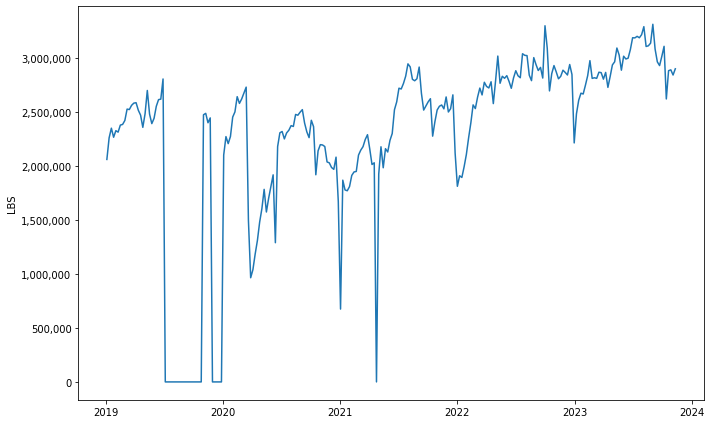

In [27]:
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator,
                               PercentFormatter,
                               StrMethodFormatter)
from matplotlib.dates import DateFormatter

fig, ax = plt.subplots()
        
ax.plot('Week Ending (Sat)', 'LBS', data=output1.groupby('Week Ending (Sat)')['LBS'].sum().reset_index())
#ax.plot('month_begin','lost_freight_pred', data=data4)
#ax.plot('month_begin','shortedquantitycs', data=data4)
#ax.legend(['total_other', 'lost_freight_pred', 'Short Cases'])

ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
ax.set_ylabel('LBS')

fig.set_size_inches((10, 6))

# Tight layout to realign things
fig.tight_layout()
plt.show()

In [11]:
output1.groupby('Week Ending (Sat)')['Cases'].sum()[-5:].reset_index()

KeyError: 'Column not found: Cases'

In [10]:
output1.groupby('Week Ending (Sat)')['LBS'].sum().pct_change(periods=1)[-6:]

Week Ending (Sat)
2023-02-11    0.033642
2023-02-18    0.041010
2023-02-25   -0.045159
2023-03-04   -0.004143
2023-03-11   -0.000327
2023-03-18    0.018091
Name: LBS, dtype: float64

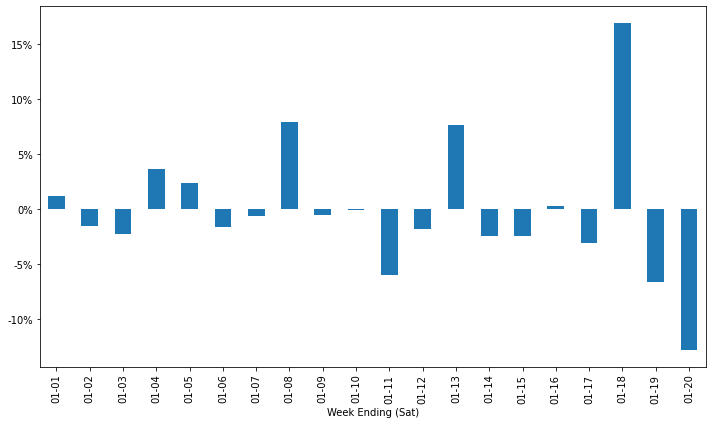

In [28]:
fig, ax = plt.subplots()

output1.groupby('Week Ending (Sat)')['LBS'].sum().pct_change(periods=1)[-20:].plot(kind='bar', ax=ax)

ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0%}'))
ax.xaxis.set_major_formatter(DateFormatter('%m-%d'))

fig.set_size_inches((10, 6))

# Tight layout to realign things
fig.tight_layout()
plt.show()

In [11]:
output1.groupby(['COVID Segmentation - L1'])['LBS'].sum().sort_values(ascending=False).reset_index()

,COVID Segmentation - L1,LBS
0,QSR / Fast Casual,1.306453e+08
1,Casual Dining,7.300451e+07
2,Non-Defined Segment,2.608745e+07
3,Workplace Canteens,9.205486e+06
4,Accommodation,8.892585e+06
5,Elderly Care Homes,8.439799e+06
6,Travel/Transport,8.055886e+06
7,Schools & Education,4.813077e+06
8,Hospitals & Healthcare Facilities,3.226364e+06
9,Grocery - Convenience,1.059278e+06


### 2. Data Dictionary
Run cell below

In [7]:
def us_states():
    us_state_abbrev = {
        'Alabama': 'AL',
        'Alaska': 'AK',
        'American Samoa': 'AS',
        'Arizona': 'AZ',
        'Arkansas': 'AR',
        'California': 'CA',
        'Colorado': 'CO',
        'Connecticut': 'CT',
        'Delaware': 'DE',
        'District of Columbia': 'DC',
        'Florida': 'FL',
        'Georgia': 'GA',
        'Guam': 'GU',
        'Hawaii': 'HI',
        'Idaho': 'ID',
        'Illinois': 'IL',
        'Indiana': 'IN',
        'Iowa': 'IA',
        'Kansas': 'KS',
        'Kentucky': 'KY',
        'Louisiana': 'LA',
        'Maine': 'ME',
        'Maryland': 'MD',
        'Massachusetts': 'MA',
        'Michigan': 'MI',
        'Minnesota': 'MN',
        'Mississippi': 'MS',
        'Missouri': 'MO',
        'Montana': 'MT',
        'Nebraska': 'NE',
        'Nevada': 'NV',
        'New Hampshire': 'NH',
        'New Jersey': 'NJ',
        'New Mexico': 'NM',
        'New York': 'NY',
        'North Carolina': 'NC',
        'North Dakota': 'ND',
        'Northern Mariana Islands':'MP',
        'Ohio': 'OH',
        'Oklahoma': 'OK',
        'Oregon': 'OR',
        'Pennsylvania': 'PA',
        'Puerto Rico': 'PR',
        'Rhode Island': 'RI',
        'South Carolina': 'SC',
        'South Dakota': 'SD',
        'Tennessee': 'TN',
        'Texas': 'TX',
        'Utah': 'UT',
        'Vermont': 'VT',
        'Virgin Islands': 'VI',
        'Virginia': 'VA',
        'Washington': 'WA',
        'West Virginia': 'WV',
        'Wisconsin': 'WI',
        'Wyoming': 'WY'
    }

    # thank you to @kinghelix and @trevormarburger for this idea
    abbrev_us_state = dict(map(reversed, us_state_abbrev.items()))
    
    return pd.DataFrame.from_dict(abbrev_us_state, orient = 'index', columns = ['State Name']).rename_axis('State').reset_index()


def apply_dictionary(df, file_name):
    
    #create dictionary object from Excel file
    #adding sheet_name = None makes it a dictionary type
    _dict = pd.read_excel(DICTIONARY + file_name, sheet_name = None)
    
    #for testing, keys = sheet names
    #print(_dict.keys())

    #create DataFrame from dictionary object called dict (short for dictionary)
    dict_df = pd.DataFrame.from_dict(_dict['Segment Mapping'])
    
    #create DataFrame from dictionary object called cat (short for category)
    cat_df = pd.DataFrame.from_dict(_dict['Province Mapping'])
    cat_df = cat_df[['Province','Cleaned Province Name','Geographic Region']]
    
    #print shape of df (dimensions)
    print(f'Shape before adding dictionary: {df.shape}', flush = True)
    
    #testing total lbs to see if it matches after merge
    total_lbs = df['Volume (Lbs)'].sum()
    print(f'Total before dictionary: {total_lbs}', flush = True)
    
    #add lower case for merging
    dict_df['Segment-lower'] = dict_df['Segment'].str.lower()
    dict_df['Sector-lower'] = dict_df['Sector'].str.lower()
    dict_df['Sub-segment-lower'] = dict_df['Sub-segment'].str.lower()
    #fill all blanks with text 'blank' 
    #dict_df = dict_df.fillna('blank')
    #dict_df = dict_df.groupby(['McCain COVID/MWOW Segmentation','Sector-lower','Segment-lower','Updated Sector']).size().reset_index().drop(columns={0}).replace('blank', np.NaN)
    dict_df = dict_df.groupby(['McCain COVID/MWOW Segmentation','COVID Segmentation - L2','COVID Segmentation - (Restaurants)','Restaurant Service Type',
                               'Sector-lower','Segment-lower','Sub-segment-lower'], dropna = False).size().reset_index().drop(columns={0})
    
    #!!!-Update base data-!!!#
    #new rule 12/9/2020: Sector MEU-IO -> MEU
    #updated 2/25/2021: MEU0IO -> MEU
    df.loc[(df['Sector'] == 'MEU-IO') | (df['Sector'] == 'MEU0IO'),'Sector'] = 'MEU'
    df.loc[(df['Sector'] == 'MEU - IO'),'Sector'] = 'MEU'
    df.loc[(df['Sector'] == 'MEU - Unit'),'Sector'] = 'MEU'
    
    #rename columns
    df = df.rename(columns = {'?Sysco Fiscal Month':'Fiscal Month',
                              'Sysco Fiscal Month':'Fiscal Month',
                              'Sysco Fiscal Week':'Fiscal Week',
                              'Sub-segment':'Sub Segment'})
    
    #add lower case key columns for merging (removes case mismatch)
    df['City'] = df['City'].str.upper()
    df['Sector-lower'] = df['Sector'].str.lower()
    df['Segment-lower'] = df['Segment'].str.lower()
    df['Sub-segment-lower'] = df['Sub Segment'].str.lower()
    
    #remove lower case key columns
    df = df.merge(dict_df, how = 'left', left_on = ['Sector-lower', 'Segment-lower', 'Sub-segment-lower'], 
                  right_on = ['Sector-lower', 'Segment-lower', 'Sub-segment-lower']).drop(columns = {'Sector-lower','Segment-lower','Sub-segment-lower'})
    
    #add lower case for merging
    #cat_df['Sub-segment-lower'] = cat_df['Sub-segment'].str.lower()
    #cat_df = cat_df.fillna('blank')
    #cat_df = cat_df.groupby(['McCain COVID/MWOW Segmentation','Sub-segment-lower','Restaurant Segment Flag','Service Type']).size().reset_index().drop(columns={0}).replace('blank', np.NaN)
    
    #add Clean Province Name
    df = df.merge(cat_df, how = 'left', left_on = ['Province'], right_on = ['Province'])
    #                    right_on = ['McCain COVID/MWOW Segmentation', 'Sub-segment-lower']).drop(columns = {'Sub-segment-lower'})
    
    #clean up 0's in Province Name, this creates errors with Teradata queries
    df.loc[(df['Cleaned Province Name'] == 0) | (df['Cleaned Province Name'].isna()), 'Cleaned Province Name'] = 'Other'
    
    df = clean_city(df)
    
     #apply calendar week
    df = df.merge(TIME[['Fiscal Week (Sysco)', 'Calendar Week Year']], how = 'left', left_on = ['Fiscal Week'], right_on = ['Fiscal Week (Sysco)']).drop(columns = {'Fiscal Week (Sysco)'})
    
    df = df.rename(columns = {'Volume (Lbs)':'LBS',
                              'Category':'Consolidated Category'})
    
    #testing total lbs to see if it matches after merge
    total_lbs = df['LBS'].sum()
    print(f'Total after dictionary: {total_lbs}', flush = True)

    #print final shape to see if anything changes (would indicate duplicates in dictionary)
    print(f'Shape after adding dictionary: {df.shape}', flush = True)
    
    return df

### 3. Import File
Run cell below

In [8]:
def import_file(file_name):
    
    if '.csv' in file_name:
        _import = pd.read_csv(file_name, low_memory = False, thousands = ',', encoding='cp1252')
    else:
        _import = pd.read_excel(file_name)
    
    return _import

### 4. Calculation Functions
Run cell below

In [9]:
def add_rolling(df, _list):
    #groupby _list
    df = df.groupby(_list, dropna = False)[['LBS','LBS_LY','LBS_Baseline']].sum().reset_index()
    
    #set index to all but last column in list
    df = df.set_index(_list)
    
    #add new metric SMA_4 (simple moving average - 4 periods)
    #level = all but last 2 items in list
    df['LBS_Lag_1'] = df.groupby(level=_list[0:-1])['LBS'].shift(periods = 1)
    df['LBS_Lag_2'] = df.groupby(level=_list[0:-1])['LBS'].shift(periods = 2)
    df['LBS_Lag_3'] = df.groupby(level=_list[0:-1])['LBS'].shift(periods = 3)
    df['LBS_Lag_4'] = df.groupby(level=_list[0:-1])['LBS'].shift(periods = 4)
    
    df['SMA_4'] = df.groupby(level=_list[0:-1])['LBS'].apply(lambda x: x.rolling(4, min_periods=1).mean())
    df['SMA_8'] = df.groupby(level=_list[0:-1])['LBS'].apply(lambda x: x.rolling(8, min_periods=1).mean())
    df['SMA_12'] = df.groupby(level=_list[0:-1])['LBS'].apply(lambda x: x.rolling(12, min_periods=1).mean())
    
    df['SMA_4_LY'] = df.groupby(level=_list[0:-1])['LBS_LY'].apply(lambda x: x.rolling(4, min_periods=1).mean())
    df['SMA_8_LY'] = df.groupby(level=_list[0:-1])['LBS_LY'].apply(lambda x: x.rolling(8, min_periods=1).mean())
    df['SMA_12_LY'] = df.groupby(level=_list[0:-1])['LBS_LY'].apply(lambda x: x.rolling(12, min_periods=1).mean())
    
    df['SMA_4_Baseline'] = df.groupby(level=_list[0:-1])['LBS_Baseline'].apply(lambda x: x.rolling(4, min_periods=1).mean())
    df['SMA_8_Baseline'] = df.groupby(level=_list[0:-1])['LBS_Baseline'].apply(lambda x: x.rolling(8, min_periods=1).mean())
    df['SMA_12_Baseline'] = df.groupby(level=_list[0:-1])['LBS_Baseline'].apply(lambda x: x.rolling(12, min_periods=1).mean())
    
    df['LBS_Baseline_Lag_1'] = df.groupby(level=_list[0:-1])['LBS_Baseline'].shift(periods = 1)
    df['LBS_LY_Lag_1'] = df.groupby(level=_list[0:-1])['LBS'].shift(periods = 1)
    
    df['SMA_4_Lag_1'] = df.groupby(level=_list[0:-1])['SMA_4'].shift(periods = 1)
    df['SMA_4_LY_Lag_1'] = df.groupby(level=_list[0:-1])['SMA_4_LY'].shift(periods = 1)
    df['SMA_4_Baseline_Lag_1'] = df.groupby(level=_list[0:-1])['SMA_4_Baseline'].shift(periods = 1)
    
    return df.reset_index()


def add_last_year(df, _list):
    #list of groupby columns
    #last item in list is Calendar Week Year which is used to pull previous history (Baseline Week = Calendar Week Year) of copied dataframe
    _groupby = _list.copy()
    
    _merge_yoy = _list.copy()[0:-1]
    _merge_yoy.extend(['YOY Week'])
    
    _merge_baseline = _list.copy()[0:-1]
    _merge_baseline.extend(['Baseline Week'])
    
    df1 = df.groupby(_list, dropna = False)['LBS'].sum().reset_index()
    
    #groupby _list
    df_new = df.groupby(_list, dropna = False)['LBS'].sum().reset_index()
    
    #add week dimensions to main dataframe
    df_new = df_new.merge(TIME[['Calendar Week Year','YOY Week','Baseline Week']], how = 'left', left_on = 'Calendar Week Year', right_on = 'Calendar Week Year')
    
    df_new = df_new.merge(df1, how='left', left_on=_merge_yoy, right_on=_groupby).drop(columns={'Calendar Week Year_y'}).rename(columns={'LBS_y':'LBS_LY'})
    
    df_new = df_new.merge(df1, how='left', left_on=_merge_baseline, right_on=_groupby).drop(columns={'Calendar Week Year'}).rename(columns={
        'LBS':'LBS_Baseline','Calendar Week Year_x':'Calendar Week Year','LBS_x':'LBS'})
    
    return df_new


def add_precovid(df, _list, begin, end):
    #datefield should be last in _list
    datefield = _list[-1]
          
    #remove datefield from list
    _list = _list[0:-1]
    
    #filter data not using last and rename columns
    _df = df[(df[datefield] >= begin) & (df[datefield] <= end)].groupby(_list)['LBS'].sum() / 52
    
    return df.merge(
        _df, how = 'left', left_on = _list, right_on = _list).rename(
        columns = {'LBS_x':'LBS', 'LBS_y':'LBS_PRECOVID'}).fillna(
        value = {'LBS_PRECOVID': 0})


def add_time(df):
    df = df.merge(TIME[['Calendar Week Year','Week Starting (Sun)','Week Ending (Sat)', 'COVID Week']],
                   how = 'left', 
                   on = 'Calendar Week Year')
    
    df = df.merge(TIME[['Calendar Week Year','YOY Week','Baseline Week']], how = 'left', left_on = 'Calendar Week Year', right_on = 'Calendar Week Year')
    
    return df


def analyze_1(df, _list, begin, end):
    if 'Calendar Week Year' not in _list:
        _list.extend(['Calendar Week Year'])
    
    df = full_dataframe(df, _list)
    
     #add last year lbs
    df = add_last_year(df, _list)
    
    #add rolling calculation
    df = add_rolling(df, _list)
        
    #add preCOVID baseline
    df = add_precovid(df, _list, begin, end)
    
    df = df.round({
        'LBS' : 2,    
        'SMA_4' : 2,
        'SMA_8' : 2,
        'SMA_12' : 2,
        'LBS_LY' : 2,    
        'SMA_4_LY' : 2,
        'SMA_8_LY' : 2,
        'SMA_12_LY' : 2,
        'LBS_Baseline' : 2,    
        'SMA_4_Baseline' : 2,
        'SMA_8_Baseline' : 2,
        'SMA_12_Baseline' : 2,
        'LBS_PRECOVID' : 2,
        'LBS_Lag_1' : 2,
        'LBS_Lag_2' : 2,
        'LBS_Lag_3' : 2,
        'LBS_Lag_4' : 2,
        'LBS_Baseline_Lag_1': 2,
        'LBS_LY_Lag_1': 2,
        'SMA_4_Lag_1' : 2,
        'SMA_4_LY_Lag_1' : 2,
        'SMA_4_Baseline_Lag_1' : 2
        
    }).fillna(value = {
        'LBS' : 0,    
        'SMA_4' : 0,
        'SMA_8' : 0,
        'SMA_12' : 0,
        'LBS_LY' : 0,    
        'SMA_4_LY' : 0,
        'SMA_8_LY' : 0,
        'SMA_12_LY' : 0,
        'LBS_Baseline' : 0,    
        'SMA_4_Baseline' : 0,
        'SMA_8_Baseline' : 0,
        'SMA_12_Baseline' : 0,
        'LBS_PRECOVID' : 0,
        'LBS_Lag_1' : 0,
        'LBS_Lag_2' : 0,
        'LBS_Lag_3' : 0,
        'LBS_Lag_4' : 0,
        'LBS_Baseline_Lag_1': 2,
        'LBS_LY_Lag_1': 2,
        'SMA_4_Lag_1' : 0,
        'SMA_4_LY_Lag_1' : 0,
        'SMA_4_Baseline_Lag_1' : 0
    })
    
    return df


def save_backup(df, file_name):
    
    df.to_csv(BACKUP + file_name)
    
    return


def td_to_pandas(query, cur, title=''):
    _data = []
    _start=dt.now()
    print(dt.now().strftime('%m/%d/%Y'))
    print(f'{title} Execution started...', end='', flush=True)
    cur.execute (query)
    print(f'finished. {dt.now() - _start}', flush=True) 
    _start_fetch=dt.now()
    print(f'{title} Fetching data started...', end='', flush=True)
    for row in cur.fetchall():
        _data.append(row) 
    print(f'finished. {dt.now() - _start_fetch}', flush=True) 
    _start=dt.now()
    print(f'{title} Creating DataFrame for started...', end='', flush=True)
    _df = pd.DataFrame(_data)
    _df.columns = [x[0].replace('SAP_', '').lower() for x in cur.description]
    print(f'finished. {dt.now() - _start}', flush=True)
    return _df


def td_dataframe(select_db, query):
    with teradatasql.connect(None, 
                         host='172.29.3.43',
                         user='PNWATTERS',
                         password='teradata123') as con:
        with con.cursor() as cur:
            cur.execute (select_db)
            print('Database selected!', flush=True)            
            dim_df = td_to_pandas(query, cur, 'Query:')
            print('Dim:', dim_df.shape)
    
    return dim_df


def restaurants(df):
    
    #Rename rows
    df.loc[df['COVID Segmentation - L2'] == 'Independents (IOs) / Local Eateries / Takeaway', 'COVID Segmentation - L2'] = 'IO'
    df.loc[
        (df['COVID Segmentation - L2'] == 'All Other') | 
        (df['COVID Segmentation - L2'] == 'National Account') | 
        (df['COVID Segmentation - L2'] == 'Region Chains')| 
        (df['COVID Segmentation - L2'] == 'National Accounts'),
        'COVID Segmentation - L2'] = 'Chain'
    
    return df

def process_list(df, work_list):
    
    _process = analyze_1(df, work_list, 201910, 202009)
    
    _process = restaurants(_process)
    
    _process['Distributor'] = 'Sysco CA'
    
    _process = add_time(_process)
    
    #for standardizing output
    work_list.extend(['Distributor','LBS','SMA_4','SMA_8','SMA_12',
                      'YOY Week','LBS_LY','SMA_4_LY','SMA_8_LY','SMA_12_LY',
                      'Baseline Week','LBS_Baseline','SMA_4_Baseline','SMA_8_Baseline','SMA_12_Baseline',
                      'LBS_Lag_1','LBS_Lag_2','LBS_Lag_3','LBS_Lag_4','LBS_Baseline_Lag_1','LBS_LY_Lag_1',
                      'SMA_4_Lag_1', 'SMA_4_LY_Lag_1', 'SMA_4_Baseline_Lag_1',
                      'LBS_PRECOVID','Week Starting (Sun)','Week Ending (Sat)','COVID Week'])
    
    return _process[work_list]

def full_dataframe(df, _list):
    weeks = df.groupby(['Calendar Week Year']).size().reset_index().drop(columns={0})
    segments = df.groupby(_list[0:-1]).size().reset_index().drop(columns={0})
    
    _df = segments.assign(key=1).merge(weeks.assign(key=1), how='outer', on='key').drop(columns = {'key'}) 
    
    return _df.merge(df, how = 'left', on = _list) 

def clean_city(df):
    #additional transformations
    df['City'] = df['City'].str.strip()
    df['City'] = df['City'].str.upper()
    df['City'].fillna('NA', inplace = True)
    
    cities = 'TORONTO|MONTREAL|OTTAWA|CALGARY|VANCOUVER|WINNIPEG|MONTREAL|HAMILTON|HALIFAX'
    
    #change each city name to the name of the city that matches, cleans up the city names
    for c in cities.split('|'):
        df.loc[df['City'].str.match(c), 'City'] = c
    
    #change all other cities to NA
    df.loc[~df['City'].str.match(cities), 'City'] = 'NA'
    
    return df

### 5. Sell-in vs. Sell-out
Run cell below

In [10]:
def teradata_sales(sellout):
    #SET QUERY_BAND = 'ApplicationName=MicroStrategy;Version=9.0;ClientUser=NEWATTER;Source=Vantage; Action=BEK Performance;StartTime=20200901T101924;JobID=55096;Importance=666;'  FOR SESSION;
    
    #the current week is pulled from the time dictionary table
    to_week = int(TIME[(TIME['Week Starting (Mon)'] <= dt.now()) & (TIME['Week Ending (Sun)'] >= dt.now())]['Calendar Week Year'].values)
    
    print(f'Starting Teradata connect...', flush = True)
    
    select_db = "DATABASE DL_GBL_TAS_BI"

    query = '''
    select a14.FISCAL_WEEK_NUMBER as FISCAL_WEEK_NUMBER,
    (a14.FISCAL_WEEK_NUMBER_DESCR || ' ' || a14.START_DATE_OF_SAPYW) as FISCAL_WEEK,
    a14.CALENDAR_WEEK_NAME as CALENDAR_WEEK_NUMBER,
    (a14.CALENDAR_WEEK_LONG_DESCRIPTION || ' ' || a14.START_DATE_OF_SAPYW) as CALENDAR_WEEK,
    RIGHT(a15.CUSTOMER_HIER_LVL_1,CAST(10 AS INTEGER)) as CUSTOMER_HIER_LVL_1,
    a15.CUSTOMER_HIER_LVL_1_NAME as CUSTOMER_HIER_LVL_1_NAME,
    a11.CUSTOMER_ID as CUSTOMER_ID,
    a17.CUSTOMER_NAME as CUSTOMER_NAME,
    a12.CATEGORY_SHORT_CODE as CATEGORY_SHORT_CODE,
    a12.CATEGORY_DESC as CATEGORY_DESC,
    a13.DIVISION_ID as DIVISION,
    a16.DIVISION_NAME as DIVISION_NAME,
    TRIM (LEADING '0' FROM a13.MATERIAL_ID) as MATERIAL_ID,
    a13.MATERIAL_DESCRIPTION as MATERIAL_NAME,
    sum(a11.SALES_VOLUME_WEIGHT_LBS) as ACTUAL_VOLUME_LBS
    from DL_GBL_TAS_BI.FACT_SALES_ACTUAL as a11
    join DL_GBL_TAS_BI.VW_H_PRODUCT_ALL_SALES as a12
     on (a11.MATERIAL_ID = a12.MATERIAL_ID)
    join DL_GBL_TAS_BI.D_MATERIAL_DN_ALL as a13
     on (a11.MATERIAL_ID = a13.MATERIAL_ID)
    join DL_GBL_TAS_BI.D_TIME_FY_V6 as a14
     on (a11.ACCOUNTING_PERIOD_DATE = a14.DAY_CALENDAR_DATE)
    join DL_GBL_TAS_BI.VW_H_CUSTOMER_ALL_DIVISION00 as a15
     on (a11.CUSTOMER_ID = a15.CUSTOMER and 
    a11.DISTRIBUTION_CHANNEL_ID = a15.DISTRIBUTION_CHANNEL and 
    a11.SALES_ORGANISATION_ID = a15.SALES_ORGANISATION)
    join DL_GBL_TAS_BI.D_DIVISION as a16
     on (a13.DIVISION_ID = a16.DIVISION_ID)
    join DL_GBL_TAS_BI.D_CUSTOMER as a17
     on (a11.CUSTOMER_ID = a17.CUSTOMER_ID)
    where (a11.SALES_ORGANISATION_ID in ('CA01')
     and a11.DISTRIBUTION_CHANNEL_ID in ('10')
     and RIGHT(a15.CUSTOMER_HIER_LVL_1,CAST(10 AS INTEGER)) in ('6500002815', '6500002893'))
     and a17.CUSTOMER_NAME like ('%SYSCO%')
     and a14.CALENDAR_WEEK_NAME between 201901 and ''' + str(to_week - 1) + '''
    group by a14.FISCAL_WEEK_NUMBER,
    (a14.FISCAL_WEEK_NUMBER_DESCR || ' ' || a14.START_DATE_OF_SAPYW),
    a14.CALENDAR_WEEK_NAME,
    (a14.CALENDAR_WEEK_LONG_DESCRIPTION || ' ' || a14.START_DATE_OF_SAPYW),
    RIGHT(a15.CUSTOMER_HIER_LVL_1,CAST(10 AS INTEGER)),
    a15.CUSTOMER_HIER_LVL_1_NAME,
    a11.CUSTOMER_ID,
    a17.CUSTOMER_NAME,
    a12.CATEGORY_SHORT_CODE,
    a12.CATEGORY_DESC,
    a13.DIVISION_ID,
    a16.DIVISION_NAME,
    TRIM (LEADING '0' FROM a13.MATERIAL_ID),
    a13.MATERIAL_DESCRIPTION
    ;'''

    #create dataframe using both functions td_to_pandas and td_dataframe
    df = td_dataframe(select_db, query)
    
    return teradata_transform(df, sellout)


def teradata_transform(sellin, sellout):
    #consolidates teradata sales with sellout data
    
    #convert from object datatype to float (exports as a number instead of string)
    sellin['actual_volume_lbs'] = sellin['actual_volume_lbs'].astype('float64')
    
    #rename columns for consistancy
    sellin = sellin.rename(columns = {'actual_volume_lbs':'LBS', 'calendar_week_number':'Calendar Week Year'})
    
    #transform calendar week year from teradata
    sellin['Calendar Week Year'] = pd.to_numeric(sellin['Calendar Week Year'], errors = 'coerce')

    #transform category so its consolidated
    sellin['Consolidated Category'] = sellin['category_desc']
    sellin.loc[sellin['Consolidated Category'] == 'Sweet Potato' , 'Consolidated Category'] = 'Potato'
    sellin.loc[sellin['Consolidated Category'] != 'Potato' , 'Consolidated Category'] = 'Prepared Foods'
    
    #analyze sellin data
    sellin = analyze_1(sellin, ['Consolidated Category'], 201910, 202009)
    
    #rename columns accordingly
    sellin = sellin.rename(columns = {'LBS':'MCCAIN LBS',
                                      'SMA_4':'MCCAIN SMA_4',
                                      'SMA_8':'MCCAIN SMA_8',
                                      'SMA_12':'MCCAIN SMA_12',
                                      'LBS_PRECOVID':'MCCAIN PRECOVID',
                                      'LBS_Lag_1':'MCCAIN Lag_1',
                                      'LBS_Lag_2':'MCCAIN Lag_2',
                                      'LBS_Lag_3':'MCCAIN Lag_3',
                                      'LBS_Lag_4':'MCCAIN Lag_4',
                                      'LBS_Baseline' : 'MCCAIN LBS_Baseline',
                                      'SMA_4_Baseline' : 'MCCAIN SMA_4_Baseline',
                                      'SMA_8_Baseline' : 'MCCAIN SMA_8_Baseline',
                                      'SMA_12_Baseline' : 'MCCAIN SMA_12_Baseline',
                                      'SMA_4_Lag_1':'MCCAIN SMA_4_Lag_1',
                                      'SMA_4_Baseline_Lag_1' : 'MCCAIN SMA_4_Baseline_Lag_1',
                                      'LBS_Baseline_Lag_1': 'MCCAIN LBS_Baseline_Lag_1'
                                     })
    
    #analyze sellout data
    df = analyze_1(sellout, ['Consolidated Category'], 201910, 202009)
                                    
    df = df.merge(sellin[['Calendar Week Year','Consolidated Category','MCCAIN LBS','MCCAIN SMA_4','MCCAIN SMA_8','MCCAIN SMA_12','MCCAIN PRECOVID',
                          'MCCAIN LBS_Baseline','MCCAIN SMA_4_Baseline','MCCAIN SMA_8_Baseline','MCCAIN SMA_12_Baseline',
                          'MCCAIN Lag_1', 'MCCAIN Lag_2', 'MCCAIN Lag_3', 'MCCAIN Lag_4','MCCAIN LBS_Baseline_Lag_1',
                          'MCCAIN SMA_4_Lag_1', 'MCCAIN SMA_4_Baseline_Lag_1']], how = 'left', 
                  left_on = ['Calendar Week Year','Consolidated Category'], right_on = ['Calendar Week Year','Consolidated Category'])
    
    df = df.fillna({'MCCAIN LBS': 0,
                    'MCCAIN SMA_4': 0,
                    'MCCAIN SMA_8': 0,
                    'MCCAIN SMA_12': 0,
                    'MCCAIN PRECOVID': 0,
                    'MCCAIN Lag_1': 0,
                    'MCCAIN Lag_2': 0,
                    'MCCAIN Lag_3': 0,
                    'MCCAIN Lag_4': 0,
                    'MCCAIN LBS_Baseline': 0,
                    'MCCAIN SMA_4_Baseline': 0,
                    'MCCAIN SMA_8_Baseline': 0,
                    'MCCAIN SMA_12_Baseline': 0,
                    'MCCAIN LBS_Baseline_Lag_1':0,
                    'MCCAIN SMA_4_Lag_1' : 0,
                    'MCCAIN SMA_4_Baseline_Lag_1' : 0
                   })
    
    df['Distributor'] = 'Sysco CA'

    df = add_time(df)
    
    df = df[['Consolidated Category','Distributor','Calendar Week Year',
             'LBS','SMA_4','SMA_8','SMA_12','LBS_PRECOVID',
             'LBS_Baseline','SMA_4_Baseline','SMA_8_Baseline','SMA_12_Baseline',
             'LBS_Lag_1', 'LBS_Lag_2', 'LBS_Lag_3', 'LBS_Lag_4', 'LBS_Baseline_Lag_1', 'SMA_4_Lag_1', 'SMA_4_Baseline_Lag_1',
             'MCCAIN LBS','MCCAIN SMA_4','MCCAIN SMA_8','MCCAIN SMA_12','MCCAIN PRECOVID',
             'MCCAIN LBS_Baseline','MCCAIN SMA_4_Baseline','MCCAIN SMA_8_Baseline','MCCAIN SMA_12_Baseline',
             'MCCAIN Lag_1', 'MCCAIN Lag_2', 'MCCAIN Lag_3', 'MCCAIN Lag_4','MCCAIN LBS_Baseline_Lag_1','MCCAIN SMA_4_Lag_1','MCCAIN SMA_4_Baseline_Lag_1',
             'Week Starting (Sun)','Week Ending (Sat)','COVID Week']]
    
    return df

### 6. Import Raw Data
Run cell below

In [11]:
'''
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 962813 entries, 0 to 962812
Data columns (total 8 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Fiscal Week               962813 non-null  int64  
 1   Dates                     962813 non-null  object 
 2   Account Type              962813 non-null  object 
 3   Customer (Address) STATE  962813 non-null  object 
 4   NPD Segmentation          930314 non-null  object 
 5   CS                        962813 non-null  float64
 6   LBS                       962813 non-null  float64
 7   Category                  962813 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 58.8+ MB
'''

import_path = r'C:\Users\newatter\OneDrive - McCain Foods Limited\Weekly Update Files\2022-08-05\Data Sources\Sysco CA Weekly Update_old.csv'

#create main dataframe from base file
#_import = import_file(PATH + 'Sysco CA Weekly Update.csv')
_import = import_file(import_path)

print(f'Imported {_import.shape[0]} records', flush = True)

Imported 1431839 records


### 7. Apply Dictionary to Raw Data and check for missing classifications
Run cell below

In [14]:
#add dictionary to base data
_base = apply_dictionary(_import, 'Sysco - CA.xlsx').dropna(subset = {'Calendar Week Year'}).astype({'Calendar Week Year':'int64'})

#check for COVID Segmentation - L1
missing = _base[_base['McCain COVID/MWOW Segmentation'].isna()].groupby(['Segment','Sub Segment','Sector'], 
                                                                     as_index = False, dropna = False)['LBS'].sum()

if len(missing) > 0:
    print('The following segments are missing:')
    display(missing)
    missing.to_excel(DICTIONARY + 'Segments Missing Dump\\' + dt.now().strftime('%Y%m%d') + '_sysco_ca_L1_missing.xlsx')
else:
    print(f'Nothing missing for COVID Segmentation - L1', flush = True)

Shape before adding dictionary: (1431839, 10)
Total before dictionary: 407664038.24999994
Total after dictionary: 407664038.24999994
Shape after adding dictionary: (1431839, 17)
Nothing missing for COVID Segmentation - L1


### 9. Execute Analysis
Run cell below

In [20]:

_list = []

#Output 1: COVID L1 - List 0
_list.append(['City','Cleaned Province Name','McCain COVID/MWOW Segmentation','COVID Segmentation - L2','Restaurant Service Type','Consolidated Category'])

print(f'Processing Region', flush = True)
output1 = process_list(_base, _list[0])
#output1 = process_list(df, _list[0])

print(f'Processing Sell in vs Sell out', flush = True)
#output2 = teradata_sales(_base)


print('All done')

Processing Region
Processing Sell in vs Sell out
All done


In [21]:
output1.to_csv('files/sysco_ca_test.zip', compression='zip', index=False)

### 9.1 Latest Date

In [49]:
output1['Week Ending (Sat)'].value_counts()

2020-07-04    30
2021-07-17    30
2022-01-01    30
2021-12-25    30
2021-12-18    30
              ..
2021-02-13    30
2021-02-06    30
2021-01-30    30
2021-01-23    30
2022-07-09    30
Name: Week Ending (Sat), Length: 105, dtype: int64

### 10. Upload Analysis to Teradata
Run cell below

In [11]:
def td_upload(select_db, df, table_name):
    with teradatasql.connect(None, 
                         host='172.29.3.43',
                         user='PNWATTERS',
                         password='teradata123') as con:
        with con.cursor() as cur:
            cur.execute (select_db)
            d = dt.now().strftime('%m/%d/%Y %H:%M:%S %p')
            print(f'Database selected! {d}', flush=True)            

            delete_from_td(df, table_name, cur)
            insert_into_td(df, table_name, cur)

def delete_from_td(df, table_name, cur):
    distributor = df.groupby('Distributor').size().reset_index().drop(columns=0).to_numpy()[0][0]
    
    print(f'Deleting records for: {distributor} in table: {table_name}', flush = True)          
        
    query = '''
    DELETE FROM ''' + table_name  + ''' 
    WHERE "Distributor" = ''' + "'" + distributor + "'"
    
    cur.execute (query)
    
def insert_into_td(df, table_name, cur):
    insert_list = df.values.tolist()
    
    #creates ?, ?,.... string used in query for teradata fastload
    insert_columns = ('?, ' * len(df.columns)).rstrip(', ')
    
    print(f'Inserting records into {table_name}', flush = True)
    
    query = "INSERT INTO " + table_name  + " (" + insert_columns + ")"
    #query = "{fn teradata_try_fastload}INSERT INTO " + table_name  + " (" + insert_columns + ")"
    
    cur.execute (query, insert_list)
    
    print(f'Inserted {df.shape[0]} records', flush = True)
    

select_db = 'DATABASE DL_NA_PROTOTYPING'

td_upload(select_db, output1, 'SELLOUT_REGION')
td_upload(select_db, output2, 'SELLOUT_AND_SELLIN')


Database selected! 07/21/2022 12:40:51 PM
Deleting records for: Sysco CA in table: SELLOUT_REGION
Inserting records into SELLOUT_REGION
Inserted 161690 records
Database selected! 07/21/2022 12:44:10 PM
Deleting records for: Sysco CA in table: SELLOUT_AND_SELLIN
Inserting records into SELLOUT_AND_SELLIN
Inserted 370 records


# Testing Datasets

In [22]:
test1 = pd.read_csv('files\sellout_region_sysco_ca.zip')
test2 = pd.read_csv('files\sysco_ca_test.zip')

print(test1.shape)
print(test2.shape)

(3330, 35)
(152240, 35)


In [23]:
test1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3330 entries, 0 to 3329
Data columns (total 35 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   City                     0 non-null      float64
 1   Region                   0 non-null      float64
 2   COVID Segmentation - L1  3330 non-null   object 
 3   COVID Segmentation - L2  3330 non-null   object 
 4   Restaurant Service Type  3330 non-null   object 
 5   Consolidated Category    3330 non-null   object 
 6   Calendar Week Year       3330 non-null   int64  
 7   Distributor              3330 non-null   object 
 8   LBS                      3330 non-null   float64
 9   SMA_4                    3330 non-null   float64
 10  SMA_8                    3330 non-null   float64
 11  SMA_12                   3330 non-null   float64
 12  YOY Week                 3300 non-null   float64
 13  LBS_LY                   3330 non-null   float64
 14  SMA_4_LY                

In [25]:
#1 = current dataset
#2 = previous dataset

df1 = test1.groupby(['Calendar Week Year','Week Ending (Sat)'])['LBS'].sum().reset_index()
df2 = test2.groupby(['Calendar Week Year'])['LBS'].sum().reset_index()

df = df1.merge(df2, how='inner', on='Calendar Week Year').rename(columns={'LBS_x':'LBS_1','LBS_y':'LBS_2'})

df.head()

,Calendar Week Year,Week Ending (Sat),LBS_1,LBS_2
0,202024,2020-06-13,1277987.00,1926852.02
1,202025,2020-06-20,2157953.71,2165471.73
2,202026,2020-06-27,2291738.94,2298567.50
3,202027,2020-07-04,2295792.48,2302066.66
4,202028,2020-07-11,2228420.41,2234712.31


In [43]:

before=df['LBS_1'].values
after=df['LBS_2'].values


weight_df=pd.DataFrame({"weight_before":before,
                         "weight_after":after,
                         "weight_change":after-before})

weight_df.describe()


,weight_before,weight_after,weight_change
count,1.000000e+02,1.000000e+02,100.000000
mean,2.301629e+06,2.321049e+06,19419.810800
std,3.686145e+05,3.290531e+05,139058.424658
min,6.728072e+05,1.382287e+06,-241812.800000
25%,2.078062e+06,2.083829e+06,-22722.967500
50%,2.301879e+06,2.308115e+06,6163.975000
75%,2.555949e+06,2.563378e+06,7110.727500
max,2.986806e+06,2.991356e+06,709480.240000


In [28]:
import scipy.stats as stats

stats.ttest_ind(a=before,b=after,equal_var=False)

Ttest_indResult(statistic=-0.39301971962993243, pvalue=0.6947331364137006)

In [45]:
df.to_csv('files\sysco_ca_test_results.csv', index=False)